In [34]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))
print(pd.Series(y_resampled).value_counts())

[(0, 4674), (1, 4674), (2, 4674)]
2    4674
1    4674
0    4674
dtype: int64


In [1]:
# ! pip install imbalanced-learn

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

import pickle
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
df = pd.read_csv("final_data.csv")
df.head(5)

,gender,age(year),race_and_hispanic_origin,country_of_birth,usa_citizenship,highest_education_grade_received,marital_status,no_of_people_in_the_household,family_size,total_family_income,veteran_status,e_cigarette_use
0,2.0,48.0,3.0,1.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,Did not smoke
1,1.0,16.0,4.0,1.0,1.0,4.0,1.0,4.0,4.0,7.0,2.0,Did not smoke
2,1.0,64.0,4.0,1.0,1.0,4.0,1.0,3.0,3.0,7.0,2.0,Did not smoke
3,1.0,61.0,1.0,1.0,1.0,3.0,1.0,4.0,4.0,4.0,1.0,Did not smoke
4,1.0,31.0,4.0,1.0,1.0,4.0,5.0,4.0,1.0,7.0,1.0,Smoked


In [4]:
df["e_cigarette_use"].value_counts()

Did not smoke    12465
Smoked             199
Name: e_cigarette_use, dtype: int64

In [5]:
df["e_cigarette_use"] = df["e_cigarette_use"].map({"Smoked": 1, "Did not smoke": 0})
selected_features = ['gender', 'age(year)', 'race_and_hispanic_origin', 'country_of_birth',
                     'marital_status', 'veteran_status', 'highest_education_grade_received', "e_cigarette_use"]
df = df[selected_features]
df

,gender,age(year),race_and_hispanic_origin,country_of_birth,marital_status,veteran_status,highest_education_grade_received,e_cigarette_use
0,2.0,48.0,3.0,1.0,1.0,2.0,3.0,0
1,1.0,16.0,4.0,1.0,1.0,2.0,4.0,0
2,1.0,64.0,4.0,1.0,1.0,2.0,4.0,0
3,1.0,61.0,1.0,1.0,1.0,1.0,3.0,0
4,1.0,31.0,4.0,1.0,5.0,1.0,4.0,1
...,...,...,...,...,...,...,...,...
12659,1.0,34.0,3.0,2.0,5.0,2.0,2.0,0
12660,2.0,67.0,6.0,2.0,1.0,2.0,3.0,0
12661,2.0,36.0,6.0,2.0,5.0,2.0,3.0,1
12662,1.0,45.0,3.0,2.0,1.0,2.0,5.0,0


In [6]:
# Upsampling by Random Oversampling

from collections import Counter

# Count class frequencies
class_counts = Counter(df["e_cigarette_use"])

# Identify the minority class
minority_class = min(class_counts, key=class_counts.get)

# Calculate the number of times to duplicate the minority class
duplicate_factor = class_counts[1 - minority_class] / class_counts[minority_class]

# Upsample the minority class by randomly duplicating examples
upsampled_df = pd.concat([
    df,
    df[df["e_cigarette_use"] == minority_class].sample(
        replace=True, n=int(duplicate_factor * len(df[df["e_cigarette_use"] == minority_class]))
    )
])

# Check class distribution after upsampling
print(upsampled_df["e_cigarette_use"].value_counts())

1    12664
0    12465
Name: e_cigarette_use, dtype: int64


In [ ]:
# X = upsampled_df.drop("e_cigarette_use", axis=1) 
# y = upsampled_df["e_cigarette_use"]

In [8]:
X = df.drop("e_cigarette_use", axis=1) 
y = df["e_cigarette_use"]

In [24]:
# Upsampling using ADASYN

adasyn = ADASYN(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

In [26]:
# Undersampling using ADASYN

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [28]:
X = df.drop("e_cigarette_use", axis=1) 
y = df["e_cigarette_use"]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [29]:
model_log_rex = LogisticRegression(penalty="l2", max_iter=1000)
param_grid_log_rex = {'C': [0.0001, 0.001, 0.01, 0.01, 0.1, 1, 10, 100, 1000, 1000]}

logrex = GridSearchCV(model_log_rex, param_grid_log_rex, cv=10)
logrex.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.01, 0.1, 1, 10, 100, 1000,
                               1000]})

In [31]:
best_params_log_rex = logrex.best_params_
best_model_log_rex = logrex.best_estimator_
test_accuracy_log_rex = best_model_log_rex.score(X_test, y_test)

print(best_params_log_rex)
print(test_accuracy_log_rex)

{'C': 0.1}
0.6375


In [13]:
with open("log_rex_model.pkl", mode="wb") as file:
    pickle.dump(best_model_log_rex, file)

<IPython.core.display.Javascript object>


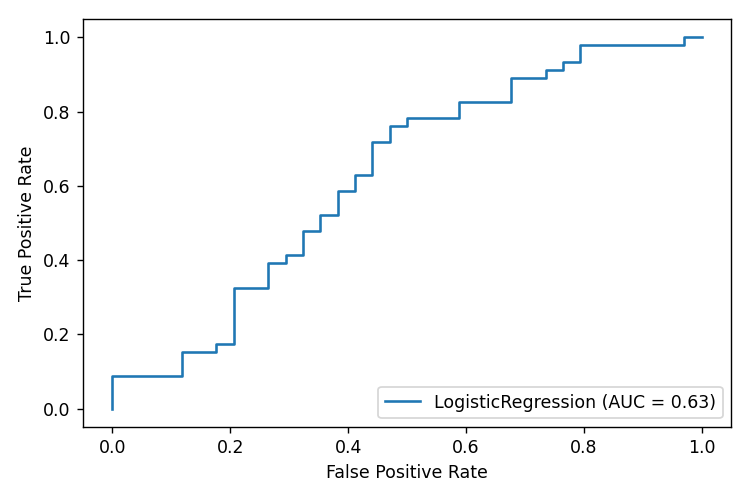

In [32]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
RocCurveDisplay.from_estimator(best_model_log_rex, X_test, y_test, ax=ax)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
fig.tight_layout()
plt.savefig("model_AUC.png")